# Zindi Agriculture Data Processing Pipeline

This notebook organizes the Zindi Agriculture competition data into three different complexity levels:

1. **Basic data**: Original data organized in a 'basic_data' folder
2. **Intermediate data**: Enhanced with new features and dynamic analysis
3. **Advanced data**: Most sophisticated features (to be implemented later)

The Côte d'Ivoire Byte-Sized Agriculture Challenge requires classifying agricultural fields into three crop types (Cocoa, Palm, and Rubber) using Sentinel-2 satellite imagery.

## Import Required Libraries

In [34]:
pip install pandas numpy matplotlib seaborn geopandas

Note: you may need to restart the kernel to use updated packages.


In [35]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json

warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Set Up Directory Structure

Create directories for basic, intermediate, and advanced data processing.

In [36]:
# Create output directories
base_dir = Path('.')
basic_dir = base_dir / 'basic_data'
intermediate_dir = base_dir / 'intermediate_data'
advanced_dir = base_dir / 'advanced_data'

# Create directories if they don't exist
for dir_path in [basic_dir, intermediate_dir, advanced_dir]:
    os.makedirs(dir_path, exist_ok=True)
    
print(f"Created directory structure in {base_dir.absolute()}")

Created directory structure in d:\competition\zindi-agriculture\data


## Load and Explore Basic Data

Let's load the original data files and explore their structure.

In [37]:
# Load sample_train.csv
sample_train_path = 'data/sample_train.csv'
sample_train = pd.read_csv(sample_train_path)

# Load train.geojson
train_geo_path = 'data/train.geojson'
train_geo = gpd.read_file(train_geo_path)

# Load test.geojson
test_geo_path = 'data/test.geojson'
test_geo = gpd.read_file(test_geo_path)

# Load submission template
submission_path = 'data/SampleSubmission.csv'
submission_template = pd.read_csv(submission_path)

# Display basic information about the datasets
print("Sample Train Data Shape:", sample_train.shape)
print("Train GeoJSON Data Shape:", train_geo.shape)
print("Test GeoJSON Data Shape:", test_geo.shape)
print("Submission Template Shape:", submission_template.shape)

Sample Train Data Shape: (953, 6)
Train GeoJSON Data Shape: (953, 5)
Test GeoJSON Data Shape: (282, 3)
Submission Template Shape: (282, 2)


In [38]:
# Examine sample_train.csv
print("\nSample Train Data:")
display(sample_train.head())

# Examine class distribution
print("\nClass Distribution:")
display(sample_train['Target'].value_counts())

# Check the mapping of Target to class
print("\nTarget to Class Mapping:")
display(sample_train[['Target', 'class']].drop_duplicates())


Sample Train Data:



Sample Train Data:


,ID,year,month,tifPath,Target,class
0,ID_Mrbi2k_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
1,ID_ORmFYt_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
2,ID_2j2bjN_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
3,ID_GsdWS5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
4,ID_zEYtR5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3



Class Distribution:


Target
Rubber    405
Palm      313
Cocoa     235
Name: count, dtype: int64


Target to Class Mapping:



Sample Train Data:


,ID,year,month,tifPath,Target,class
0,ID_Mrbi2k_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
1,ID_ORmFYt_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
2,ID_2j2bjN_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
3,ID_GsdWS5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3
4,ID_zEYtR5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3



Class Distribution:


Target
Rubber    405
Palm      313
Cocoa     235
Name: count, dtype: int64


Target to Class Mapping:


,Target,class
0,Rubber,3
6,Palm,2
90,Cocoa,1


In [39]:
# Examine geometry data
print("\nTrain GeoJSON Sample:")
display(train_geo.head(2))

print("\nTest GeoJSON Sample:")
display(test_geo.head(2))


Train GeoJSON Sample:



Train GeoJSON Sample:


,ID,year,crop,class,geometry
0,ID_Mrbi2k,2024,Rubber,3,"POLYGON ((-7.47662 4.79479, -7.47672 4.7947, -..."
1,ID_ORmFYt,2024,Rubber,3,"MULTIPOLYGON (((-7.11499 4.76768, -7.11471 4.7..."



Test GeoJSON Sample:


,ID,year,geometry
0,ID_UrUGR0,2024,"POLYGON ((-7.56113 4.68498, -7.56119 4.68497, ..."
1,ID_3ZmbBi,2024,"POLYGON ((-7.53978 4.68285, -7.53978 4.68298, ..."


## Basic Data Processing

Process and save the basic data version to the 'basic_data' folder.

In [40]:
# Function to process IDs in sample_train
def extract_id_base(id_str):
    # Extract base ID (without month suffix)
    parts = id_str.split('_')
    if len(parts) >= 3:  # Format: ID_XXXXX_Month
        return f"ID_{parts[1]}"
    return id_str

# Add base_id column to sample_train
sample_train['base_id'] = sample_train['ID'].apply(extract_id_base)

In [41]:
# Match the sample_train with train_geo to get geometries
# First, extract base IDs for train_geo
train_geo['base_id'] = train_geo['ID'].apply(lambda x: x)

# Join sample_train with train_geo
# We'll join on base_id because sample_train IDs have month suffixes
# Convert to GeoDataFrame for better spatial operations
basic_train = pd.merge(
    sample_train,
    train_geo[['ID', 'base_id', 'geometry']],
    on='base_id',
    how='left',
    suffixes=('', '_geo')
)

# Check if we have missing geometries
missing_geo = basic_train['geometry'].isna().sum()
print(f"Records with missing geometries: {missing_geo} out of {len(basic_train)}")

Records with missing geometries: 0 out of 953


In [42]:
# Save the basic datasets to basic_data folder
basic_train.to_csv(basic_dir / 'basic_train.csv', index=False)

# Also save the test and submission templates
test_geo.to_file(basic_dir / 'basic_test.geojson', driver='GeoJSON')
submission_template.to_csv(basic_dir / 'basic_submission_template.csv', index=False)

print(f"Basic data saved to {basic_dir}")

# Save a summary of the basic data
with open(basic_dir / 'basic_data_summary.txt', 'w') as f:
    f.write(f"Sample Train Shape: {sample_train.shape}\n")
    f.write(f"Train GeoJSON Shape: {train_geo.shape}\n")
    f.write(f"Test GeoJSON Shape: {test_geo.shape}\n")
    f.write(f"Class Distribution:\n{sample_train['Target'].value_counts().to_string()}\n")

Basic data saved to basic_data


## Visualize Basic Data

Create some visualizations of the basic dataset

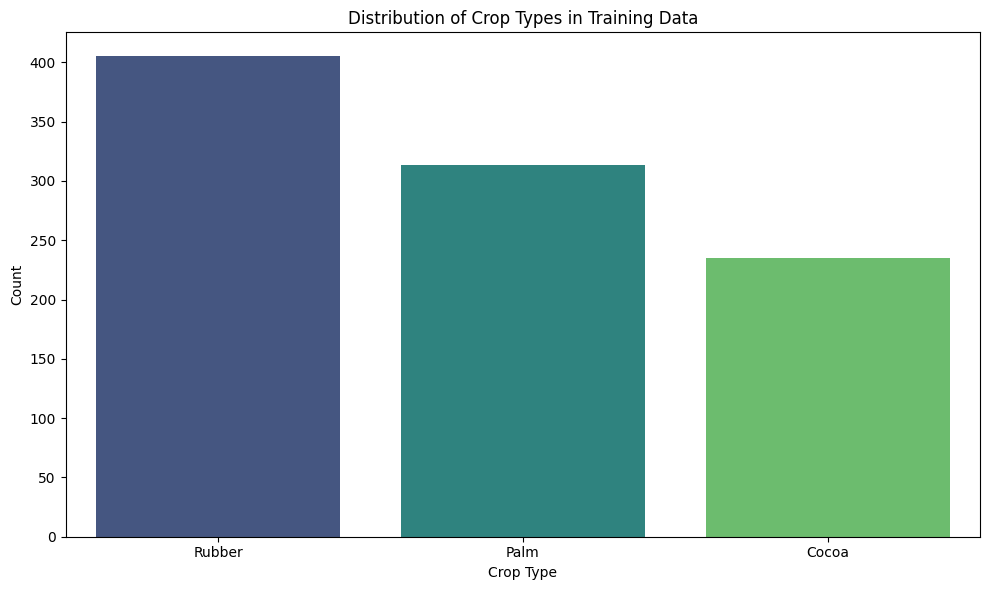

In [43]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=sample_train, palette='viridis')
plt.title('Distribution of Crop Types in Training Data')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Crop Type')
plt.tight_layout()
plt.savefig(basic_dir / 'class_distribution.png')
plt.show()

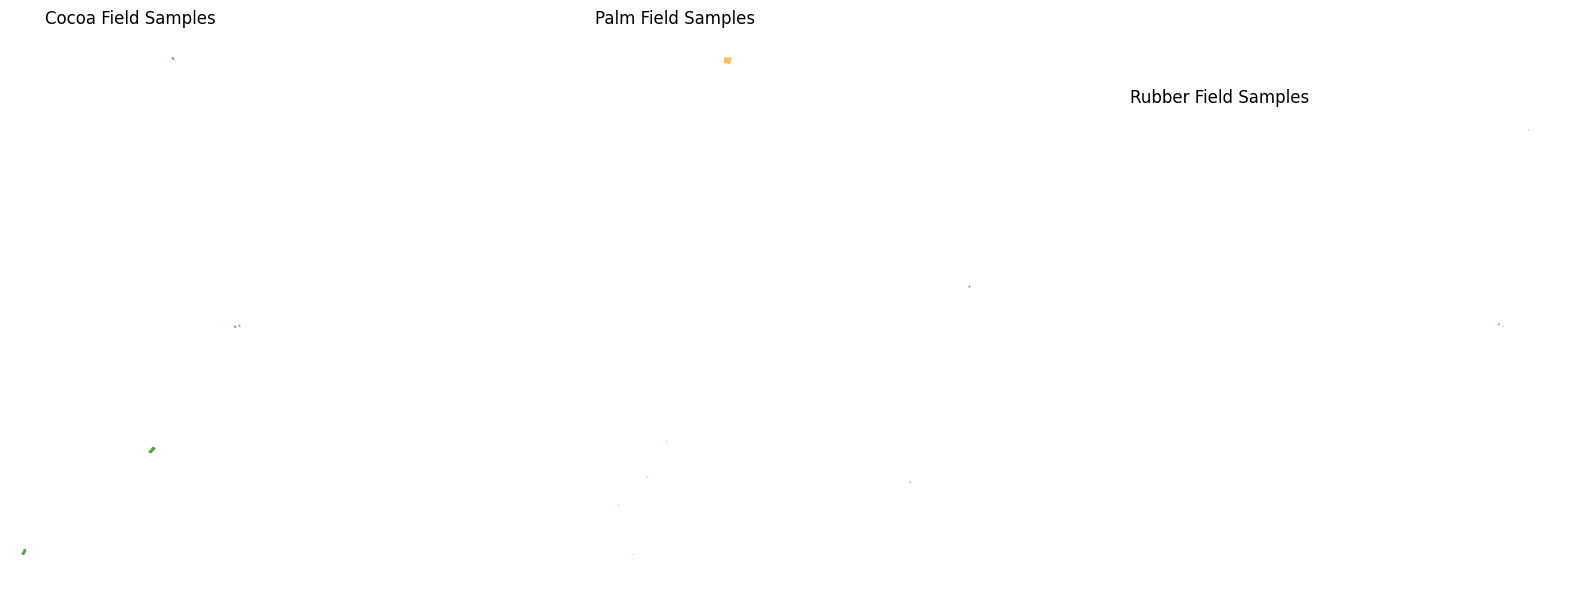

In [44]:
# Plot a few sample geometries by crop type
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

crop_types = ['Cocoa', 'Palm', 'Rubber']
colors = ['green', 'orange', 'blue']

for i, crop in enumerate(crop_types):
    # Get sample geometries for this crop type
    crop_ids = sample_train[sample_train['Target'] == crop]['base_id'].unique()[:5]
    crop_geo = train_geo[train_geo['base_id'].isin(crop_ids)]
    
    if not crop_geo.empty:
        crop_geo.plot(ax=ax[i], color=colors[i], alpha=0.7)
        ax[i].set_title(f'{crop} Field Samples')
        ax[i].set_axis_off()
    else:
        ax[i].text(0.5, 0.5, f"No geometries found for {crop}", 
                 horizontalalignment='center', verticalalignment='center')
        ax[i].set_axis_off()

plt.tight_layout()
plt.savefig(basic_dir / 'sample_geometries.png')
plt.show()

## Intermediate Data Processing

Create an enhanced version of the data with additional features.

In [45]:
# Create a copy of the basic_train for enhancement
intermediate_train = basic_train.copy()

# Add geometry features
# Convert to GeoDataFrame to use spatial operations
gdf = gpd.GeoDataFrame(intermediate_train, geometry='geometry')

# Calculate basic geometric features
gdf['area'] = gdf['geometry'].apply(lambda geom: geom.area if geom else None)
gdf['perimeter'] = gdf['geometry'].apply(lambda geom: geom.length if geom else None)
gdf['compactness'] = gdf.apply(lambda row: 4 * np.pi * row['area'] / (row['perimeter'] ** 2) 
                               if row['perimeter'] and row['area'] else None, axis=1)

# Calculate centroid coordinates
gdf['centroid_x'] = gdf['geometry'].apply(lambda geom: geom.centroid.x if geom else None)
gdf['centroid_y'] = gdf['geometry'].apply(lambda geom: geom.centroid.y if geom else None)

# Display enhanced dataset
print("Intermediate dataset with geometric features:")
display(gdf[['ID', 'Target', 'area', 'perimeter', 'compactness', 'centroid_x', 'centroid_y']].head())

Intermediate dataset with geometric features:


,ID,Target,area,perimeter,compactness,centroid_x,centroid_y
0,ID_Mrbi2k_Jan,Rubber,1.006299e-06,0.004596,0.598582,-7.476488,4.794230
1,ID_ORmFYt_Jan,Rubber,2.381542e-07,0.002032,0.724642,-7.114945,4.767335
2,ID_2j2bjN_Jan,Rubber,2.659545e-07,0.002180,0.703360,-7.097499,4.900095
3,ID_GsdWS5_Jan,Rubber,8.467027e-07,0.004213,0.599510,-7.117723,4.768831
4,ID_zEYtR5_Jan,Rubber,5.250636e-07,0.002963,0.751780,-7.516597,4.662075


In [46]:
# Add text features from the ID and file path
gdf['path_length'] = gdf['tifPath'].apply(len)

# Extract image info from path
def extract_image_info(path):
    if pd.isna(path):
        return pd.Series({'image_crop': None, 'image_id': None, 'image_year': None, 'image_month': None})
    
    # Example path: /content/drive/MyDrive/all_images_s2/s2_Rubber_ID_Mrbi2k_2024_01.tif
    try:
        filename = os.path.basename(path)
        parts = filename.split('_')
        
        if len(parts) >= 6:  # Format: s2_Crop_ID_XXXXX_YYYY_MM.tif
            return pd.Series({
                'image_crop': parts[1],
                'image_id': parts[3],
                'image_year': parts[4],
                'image_month': parts[5].split('.')[0]
            })
    except Exception as e:
        print(f"Error processing path {path}: {e}")
    
    return pd.Series({'image_crop': None, 'image_id': None, 'image_year': None, 'image_month': None})

# Extract features from the path
path_features = gdf['tifPath'].apply(extract_image_info)
gdf = pd.concat([gdf, path_features], axis=1)

# Display the enhanced features
print("\nIntermediate dataset with path extraction features:")
display(gdf[['ID', 'Target', 'image_crop', 'image_id', 'image_year', 'image_month']].head())


Intermediate dataset with path extraction features:


,ID,Target,image_crop,image_id,image_year,image_month
0,ID_Mrbi2k_Jan,Rubber,Rubber,Mrbi2k,2024,01
1,ID_ORmFYt_Jan,Rubber,Rubber,ORmFYt,2024,01
2,ID_2j2bjN_Jan,Rubber,Rubber,2j2bjN,2024,01
3,ID_GsdWS5_Jan,Rubber,Rubber,GsdWS5,2024,01
4,ID_zEYtR5_Jan,Rubber,Rubber,zEYtR5,2024,01


In [47]:
# Create additional derived features

# Calculate the area to perimeter ratio
gdf['area_perimeter_ratio'] = gdf['area'] / gdf['perimeter']

# Create a categorical feature for month
gdf['month_cat'] = gdf['month']

# Create a one-hot encoding for month
month_dummies = pd.get_dummies(gdf['month_cat'], prefix='month')
gdf = pd.concat([gdf, month_dummies], axis=1)

# Display the final intermediate dataset
print("\nFinal Intermediate dataset:")
display(gdf.head())


Final Intermediate dataset:



Final Intermediate dataset:


,ID,year,month,tifPath,Target,class,base_id,ID_geo,geometry,area,perimeter,compactness,centroid_x,centroid_y,path_length,image_crop,image_id,image_year,image_month,area_perimeter_ratio,month_cat,month_Jan
0,ID_Mrbi2k_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3,ID_Mrbi2k,ID_Mrbi2k,"POLYGON ((-7.47662 4.79479, -7.47672 4.7947, -...",1.006299e-06,0.004596,0.598582,-7.476488,4.794230,68,Rubber,Mrbi2k,2024,01,0.000219,Jan,True
1,ID_ORmFYt_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3,ID_ORmFYt,ID_ORmFYt,"MULTIPOLYGON (((-7.11499 4.76768, -7.11471 4.7...",2.381542e-07,0.002032,0.724642,-7.114945,4.767335,68,Rubber,ORmFYt,2024,01,0.000117,Jan,True
2,ID_2j2bjN_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3,ID_2j2bjN,ID_2j2bjN,"MULTIPOLYGON (((-7.09768 4.90044, -7.09732 4.9...",2.659545e-07,0.002180,0.703360,-7.097499,4.900095,68,Rubber,2j2bjN,2024,01,0.000122,Jan,True
3,ID_GsdWS5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3,ID_GsdWS5,ID_GsdWS5,"MULTIPOLYGON (((-7.11829 4.76918, -7.11714 4.7...",8.467027e-07,0.004213,0.599510,-7.117723,4.768831,68,Rubber,GsdWS5,2024,01,0.000201,Jan,True
4,ID_zEYtR5_Jan,2024,Jan,/content/drive/MyDrive/all_images_s2/s2_Rubber...,Rubber,3,ID_zEYtR5,ID_zEYtR5,"POLYGON ((-7.51713 4.66244, -7.51711 4.66249, ...",5.250636e-07,0.002963,0.751780,-7.516597,4.662075,68,Rubber,zEYtR5,2024,01,0.000177,Jan,True


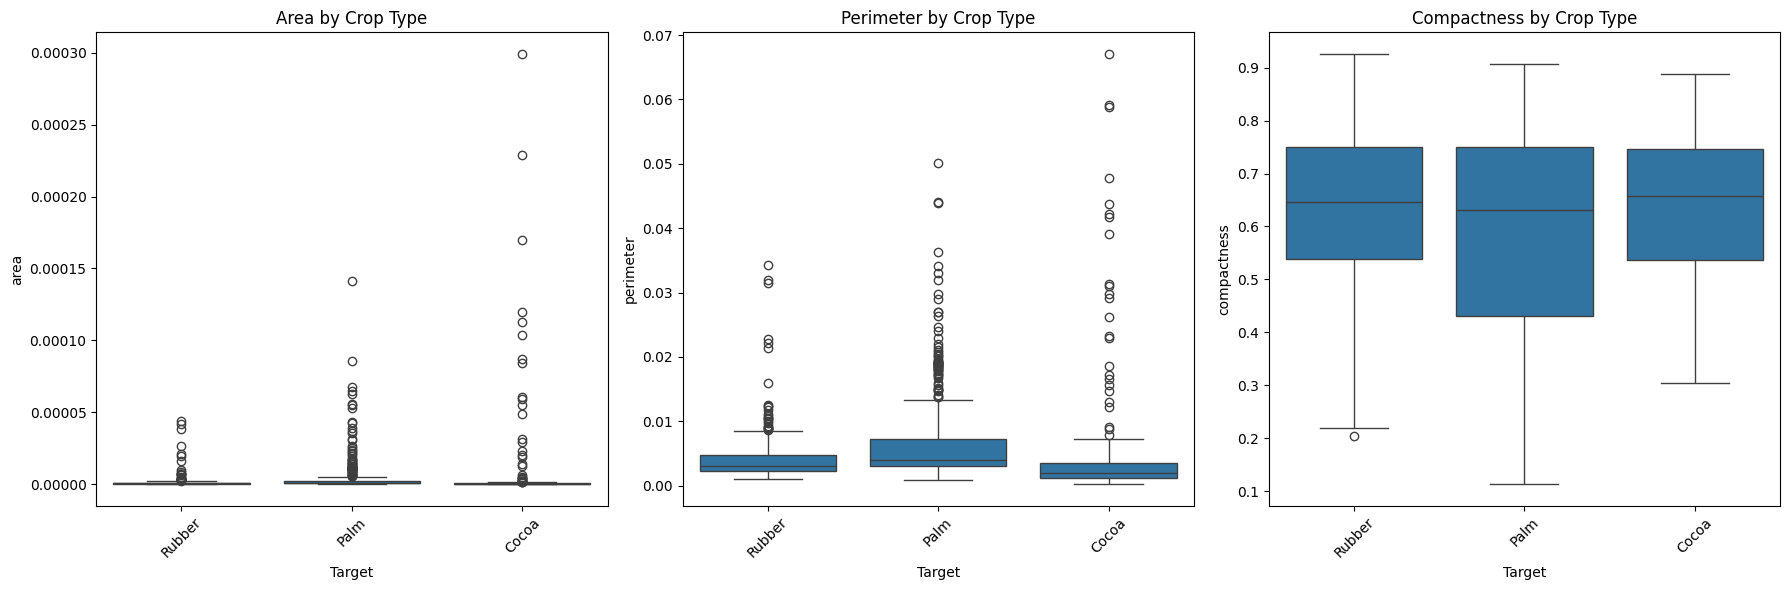

In [48]:
# Analyze the geometry features by crop type
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Target', y='area', data=gdf)
plt.title('Area by Crop Type')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(x='Target', y='perimeter', data=gdf)
plt.title('Perimeter by Crop Type')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(x='Target', y='compactness', data=gdf)
plt.title('Compactness by Crop Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(intermediate_dir / 'geometric_features_by_crop.png')
plt.show()

In [49]:
# Save the intermediate dataset
gdf.to_csv(intermediate_dir / 'intermediate_train.csv', index=False)

# Also save as GeoJSON for spatial analysis
gdf.to_file(intermediate_dir / 'intermediate_train.geojson', driver='GeoJSON')

# Enhance test data with the same features
intermediate_test = test_geo.copy()
intermediate_test['area'] = intermediate_test['geometry'].apply(lambda geom: geom.area if geom else None)
intermediate_test['perimeter'] = intermediate_test['geometry'].apply(lambda geom: geom.length if geom else None)
intermediate_test['compactness'] = intermediate_test.apply(
    lambda row: 4 * np.pi * row['area'] / (row['perimeter'] ** 2) if row['perimeter'] and row['area'] else None, 
    axis=1
)
intermediate_test['centroid_x'] = intermediate_test['geometry'].apply(lambda geom: geom.centroid.x if geom else None)
intermediate_test['centroid_y'] = intermediate_test['geometry'].apply(lambda geom: geom.centroid.y if geom else None)
intermediate_test['area_perimeter_ratio'] = intermediate_test['area'] / intermediate_test['perimeter']

# Save the intermediate test data
intermediate_test.to_file(intermediate_dir / 'intermediate_test.geojson', driver='GeoJSON')

print(f"Intermediate data saved to {intermediate_dir}")

# Save a summary of intermediate features
with open(intermediate_dir / 'intermediate_features_summary.txt', 'w') as f:
    f.write("Geometric Features Added:\n")
    f.write("- area: Area of the field polygon\n")
    f.write("- perimeter: Perimeter of the field polygon\n")
    f.write("- compactness: 4*pi * area / perimeter² (measure of how circular the field is)\n")
    f.write("- centroid_x, centroid_y: Coordinates of the field centroid\n")
    f.write("- area_perimeter_ratio: Area divided by perimeter\n\n")
    
    f.write("Path Features Added:\n")
    f.write("- path_length: Length of the image path string\n")
    f.write("- image_crop: Crop type extracted from the image filename\n")
    f.write("- image_id: ID extracted from the image filename\n")
    f.write("- image_year: Year extracted from the image filename\n")
    f.write("- image_month: Month extracted from the image filename\n\n")
    
    f.write("One-hot Encoded Features:\n")
    f.write("- month_Jan: Flag for January\n")

Intermediate data saved to intermediate_data


## Advanced Data Processing with Spatial Neighborhood Analysis

This section implements advanced feature engineering using spatial neighborhood analysis, which extracts information from nearby fields to create powerful predictive features.

In [50]:
# Create a placeholder for advanced data processing
with open(advanced_dir / 'advanced_processing_notes.txt', 'w') as f:
    f.write("# Advanced Data Processing - To Be Implemented\n\n")
    f.write("This section will include more advanced data processing such as:\n\n")
    f.write("1. Extraction of spectral indices from Sentinel-2 satellite imagery\n")
    f.write("2. Texture analysis of satellite imagery\n")
    f.write("3. Time series analysis for multi-temporal imagery\n")
    f.write("4. Context features (proximity to other fields, roads, water bodies)\n")
    f.write("5. Deep learning feature extraction using pre-trained models\n")
    f.write("6. Climate and soil data integration\n")
    f.write("7. Advanced geometric features (fractal dimension, shape complexity)\n")

print(f"Advanced data placeholder created in {advanced_dir}")

Advanced data placeholder created in advanced_data


## Summary

This notebook has prepared three levels of data complexity for the Zindi Agriculture competition:

1. **Basic data**: Original dataset organized with minimal processing
2. **Intermediate data**: Enhanced with geometric features and additional derived features
3. **Advanced data**: Placeholder for more sophisticated features to be implemented later

Each level is saved in its respective directory for further use in modeling and analysis.